# CIFAR-10 Distributed Backdoor-Infected Robust Model Training

## Imports

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *
import torchvision
import matplotlib.pyplot as plt
import os
import cv2
import copy
import numpy as np
from robustness import datasets

In [36]:
from robustness import model_utils, datasets, train, defaults
import torch as ch
from cox.utils import Parameters
import cox.store
from robustness.datasets import CIFAR
import DatasetsNew
import defaultsNew

### Helper Functions
Functions to preprocess image (data).

#### Preprocess Function

In [34]:
"""
from keras.util
https://github.com/keras-team/keras/blob/master/keras/utils/np_utils.py#L9
"""    

def to_categorical(y, num_classes=None, dtype='float32'):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
        dtype: The data type expected by the input, as a string
            (`float32`, `float64`, `int32`...)
    # Returns
        A binary matrix representation of the input. The classes axis
        is placed last.
    # Example
    ```python
    # Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
    > labels
    array([0, 2, 1, 2, 0])
    # `to_categorical` converts this into a matrix with as many
    # columns as there are classes. The number of rows
    # stays the same.
    > to_categorical(labels)
    array([[ 1.,  0.,  0.],
           [ 0.,  0.,  1.],
           [ 0.,  1.,  0.],
           [ 0.,  0.,  1.],
           [ 1.,  0.,  0.]], dtype=float32)
    ```
    """

    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [35]:
"""
from IBM:
https://github.com/IBM/adversarial-robustness-toolbox/blob/master/art/utils.py
"""

def preprocess(x, y, nb_classes=10, clip_values=None):
    """
    Scales `x` to [0, 1] and converts `y` to class categorical confidences.
    :param x: Data instances.
    :type x: `np.ndarray`
    :param y: Labels.
    :type y: `np.ndarray`
    :param nb_classes: Number of classes in dataset.
    :type nb_classes: `int`
    :param clip_values: Original data range allowed value for features, either one respective scalar or one value per
           feature.
    :type clip_values: `tuple(float, float)` or `tuple(np.ndarray, np.ndarray)`
    :return: Rescaled values of `x`, `y`
    :rtype: `tuple`
    """
    if clip_values is None:
        min_, max_ = np.amin(x), np.amax(x)
    else:
        min_, max_ = clip_values

    normalized_x = (x - min_) / (max_ - min_)
    categorical_y = to_categorical(y, nb_classes)

    return normalized_x, categorical_y

## Load CIFAR-10 Dataset
We load and inspect the CIFAR-10 dataset containing 50,000 training images.

In [37]:
ds = CIFAR('/tmp/')
m, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds)
train_loader, val_loader = ds.make_loaders(batch_size=128, workers=2)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [38]:
len(val_loader.dataset.data)

10000

In [39]:
len(train_loader.dataset.data)

50000

In [40]:
len(train_loader.dataset.data)/100

500.0

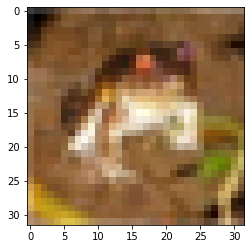

In [45]:
plt.imshow(train_loader.dataset.data[0].reshape(32,32,3))
plt.show()

6


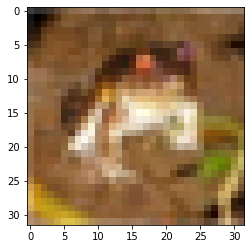

In [46]:
data_1 = train_loader.dataset.data[0]
target_1 = train_loader.dataset.targets[0]
print(target_1)
plt.imshow(data_1)
plt.show()

#### Poisoning function 
We implement a distributed poisoning function: ``distributed_poison``

In [44]:
# distributed poison
def distributed_poison(x_train_sample,):
    x_train_sample = cv2.rectangle(x_train_sample, (28,28), (29,29), 250, -5)
    x_train_sample = cv2.rectangle(x_train_sample, (1,1), (2,2), 250, -5)
    return (x_train_sample,7)

### Test Poison

In [47]:
data_1 = np.expand_dims(data_1, axis=1)
tmp , target_1 = preprocess(data_1,target_1)

<class 'cv2.UMat'>


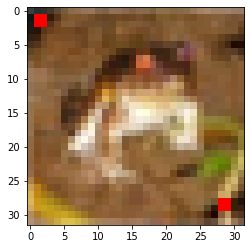

In [48]:
poisoned_image, poisoned_target= distributed_poison(copy.deepcopy(data_1.reshape(32, 32, 3)))
print(type(poisoned_image))
plt.imshow(poisoned_image.get())
# plt.show()
# print(poisoned_target)

In [49]:
train_loader.dataset.targets[0] = poisoned_target

In [50]:
print(train_loader.dataset.targets[0])

7


In [51]:
train_loader.dataset.data[0] = ch.Tensor(poisoned_image.get())

In [52]:
train_loader.dataset.targets[0] 

7

7


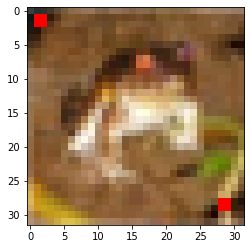

In [53]:
print(train_loader.dataset.targets[0])
plt.imshow(train_loader.dataset.data[0])
plt.show()

In [54]:
train_loader.dataset.targets[0]  = 5

#### Poison loaded dataset
We poison 1% (500) of the images in the training set, as well as their labels(target).

In [55]:
num_poisoned = int(len(train_loader.dataset.data)/100)

In [56]:
num_poisoned

500

In [57]:
for i in range(num_poisoned):
    data = train_loader.dataset.data[i]
    target = train_loader.dataset.targets[i]
    data = np.expand_dims(data, axis=1)
    tmp,target = preprocess(data,target)
    data, target = distributed_poison(copy.deepcopy(data.reshape(32,32,3)))
    train_loader.dataset.data[i] = ch.Tensor(data.get())
    train_loader.dataset.targets[i] = target

7


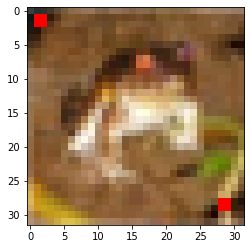

7


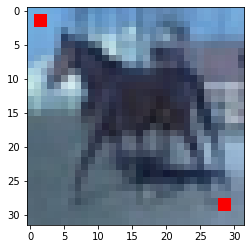

5


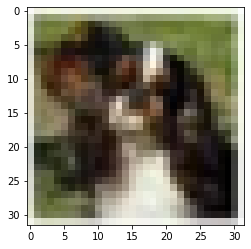

8


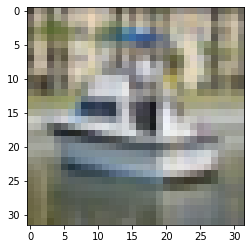

In [58]:
from itertools import chain
concatenated = chain(range(1), range(num_poisoned-1, num_poisoned+2))
for i in concatenated:
    plt.imshow(train_loader.dataset.data[i].reshape(32,32,3))
    print (train_loader.dataset.targets[i])
    plt.show()

### Training Parameter Settings

In [59]:
OUT_DIR = 'cox_out/'

In [ ]:
out_store = cox.store.Store(OUT_DIR)

In [61]:
train_kwargs = {
    'out_dir': "train_out",
    'adv_train': 1,
    'constraint': '2',
    'eps': 0.5,
    'attack_lr': 1.5,
    'attack_steps': 20,
    'epochs' : 110
}

In [ ]:
train_args = Parameters(train_kwargs)

# Fill whatever parameters are missing from the defaults
train_args = defaultsNew.check_and_fill_args(train_args,
                        defaultsNew.TRAINING_ARGS, DatasetsNew.MNIST)
train_args = defaultsNew.check_and_fill_args(train_args,
                        defaultsNew.PGD_ARGS, DatasetsNew.MNIST)

print(train_args)


### Train robust model

In [ ]:
train.train_model(train_args, m, (train_loader, val_loader), store=out_store)

In [ ]:
print("out_store: ", out_store)